In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
import os

sys.path.append(os.path.abspath("/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project"))

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Scripts import Data_v2
from Scripts import Data_analysis_func
from Scripts import Model_checks
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from Scripts import Outlier_detection_v2
from Scripts import Genes_self_similarity_v2
from matplotlib_venn import venn2, venn2_circles
from Scripts import Feature_engineering
from Scripts import Clusters
from tqdm import tqdm

In [3]:
data = Data_v2.get_format_data_without_na()

/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'elapsed_time_{i}'] = (data[col] - data[time_columns[0]]).dt.total_seconds() / 3600
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'elapsed_time_{i}'] = (data[col] - data[time_columns[0]]).dt.total_seconds() / 3600
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:117: P

In [4]:
data_norm_flagged = Data_v2.get_norm_flagged_data()

/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'elapsed_time_{i}'] = (data[col] - data[time_columns[0]]).dt.total_seconds() / 3600
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'elapsed_time_{i}'] = (data[col] - data[time_columns[0]]).dt.total_seconds() / 3600
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:116: P

In [5]:
data_slopes = Data_v2.get_simple_slope(data_norm_flagged)

In [15]:
data_slopes = pd.read_csv('/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data/database_after_preprocessing_07_11_2024.csv')

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_55576/1422724113.py:1: DtypeWarning: Columns (213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,419,420) have mixed types. Specify dtype option on import or set low_memory=False.
  data_slopes = pd.read_csv('/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data/database_after_preprocessing_07_11_2024.csv')


In [16]:
df_mutants_gene_go = data_slopes[['mutant_ID', 'mutated_genes', 'GO']].drop_duplicates(subset=['mutant_ID'])

In [17]:
df_mutants_gene_go

,mutant_ID,mutated_genes,GO
0,WT,NaN,[]
766,LMJ.RY0402.061332,Cre01.g011901,"['GO:0003824', 'GO:0008152', 'GO:0008484']"
767,LMJ.RY0402.071251,Cre11.g479350,[]
769,LMJ.RY0402.059759,Cre06.g303150,[]
770,LMJ.RY0402.063837,Cre10.g431950,"['GO:0004672', 'GO:0004713', 'GO:0005524', 'GO..."
...,...,...,...
47936,LMJ.RY0402.114464,Cre03.g152200,[]
49203,LMJ.RY0402.060169,Cre07.g352900,[]
50453,LMJ.RY0402.103346,Cre02.g077600,[]
51825,LMJ.RY0402.178432,Cre16.g670400,[]


In [18]:
import requests
from goatools.obo_parser import GODag
from collections import defaultdict

# Define the URL of the GO OBO file
obo_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
obo_file = "go-basic.obo"

# Download the GO OBO file
response = requests.get(obo_url)
with open(obo_file, 'wb') as file:
    file.write(response.content)

# Load the GO DAG
go_dag = GODag(obo_file)


# Flatten the list of GO terms and create a dictionary
go_to_mutants = defaultdict(set)
for _, row in df_mutants_gene_go.iterrows():
    mutant = row['mutant_ID']
    for go_term in row['GO']:
        go_to_mutants[go_term].add(mutant)

# Function to get parent GO terms, handling missing terms
def get_parent_go_terms(go_term, go_dag):
    if go_term in go_dag:
        return go_dag[go_term].parents
    return set()

# Aggregate mutants at different GO levels
def aggregate_mutants_at_level(go_to_mutants, go_dag, min_mutants=10):
    current_level = go_to_mutants.copy()
    while True:
        next_level = defaultdict(set)
        for go_term, mutants in current_level.items():
            if len(mutants) < min_mutants:
                for parent in get_parent_go_terms(go_term, go_dag):
                    next_level[parent.id].update(mutants)
            else:
                next_level[go_term].update(mutants)

        if all(len(mutants) >= min_mutants for mutants in next_level.values()):
            return next_level
        if not next_level:
            break
        current_level = next_level

    return current_level

# Aggregate mutants at a level where each GO term has at least 10 mutants
aggregated_go_to_mutants = aggregate_mutants_at_level(go_to_mutants, go_dag, min_mutants=20)

# Print the results
for go_term, mutants in aggregated_go_to_mutants.items():
    print(f"{go_term}: {len(mutants)} mutants")


go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms
[: 7701 mutants
]: 7701 mutants
': 4044 mutants
G: 4044 mutants
O: 4044 mutants
:: 4044 mutants
0: 4044 mutants
3: 2126 mutants
8: 2711 mutants
2: 2623 mutants
4: 2651 mutants
,: 2968 mutants
 : 2968 mutants
1: 3106 mutants
5: 3582 mutants
6: 2884 mutants
7: 1995 mutants
9: 1459 mutants


In [19]:
print("Number of aggregated GO terms:", len(aggregated_go_to_mutants))

Number of aggregated GO terms: 18


In [20]:
data.explode('GO')['GO'].value_counts()

NameError: name 'data' is not defined

In [40]:
# Function to get all GO terms for a specific mutant from aggregated_go_to_mutants
def get_go_terms_from_aggregated(mutant, aggregated_go_to_mutants):
    go_terms_for_mutant = [go_term for go_term, mutants in aggregated_go_to_mutants.items() if mutant in mutants]
    return go_terms_for_mutant

# Apply the function to each row in the dataframe to create the 'aggregated_GO' column
df_mutants_gene_go['aggregated_GO'] = df_mutants_gene_go['mutant_ID'].apply(lambda mutant: get_go_terms_from_aggregated(mutant, aggregated_go_to_mutants))

In [10]:
df_mutants_gene_go.explode('aggregated_GO')['aggregated_GO'].value_counts()

KeyError: 'aggregated_GO'

In [49]:
# merge the aggregated GO terms with the original dataframe
# data_with_GO = pd.merge(data, df_mutants_gene_go[['mutant_ID', 'aggregated_GO']], on='mutant_ID', how='left')
# data_norm_with_GO = pd.merge(data_norm_flagged, df_mutants_gene_go[['mutant_ID', 'aggregated_GO']], on='mutant_ID', how='left')
data_slopes_with_GO = pd.merge(data_slopes, df_mutants_gene_go[['mutant_ID', 'aggregated_GO']], on='mutant_ID', how='left')

In [48]:
data_slopes.drop(columns=['aggregated_GO'], inplace=True)

In [44]:
data_slopes_with_GO.drop(columns=['aggregated_GO'], inplace=True)

In [50]:
data_slopes_with_GO

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,GO,mutated_genes_light_regime_count,fv_fm_WT,fv_fm_end_WT,ynpqend_WT,flag_y2,flag_ynpq,slope_y2,slope_ynpq,aggregated_GO
0,99,M1,2023-10-12,1min-1min,16.903264,24.476540,164,0,1,-0.006258,...,[],831,0.622337,0.591999,0.011219,ok,ok,0.000334,-0.000359,[]
1,99,M1,2023-10-12,1min-1min,16.903264,24.476540,164,0,2,-0.016211,...,[],831,0.622337,0.591999,0.011219,ok,ok,-0.000393,0.000219,[]
2,99,M1,2023-10-12,1min-1min,16.903264,24.476540,164,0,3,-0.005031,...,[],831,0.622337,0.591999,0.011219,ok,ok,-0.000179,-0.000043,[]
3,99,M1,2023-10-12,1min-1min,16.903264,24.476540,164,0,4,-0.024731,...,[],831,0.622337,0.591999,0.011219,ok,ok,0.000073,-0.000106,[]
4,99,M1,2023-10-12,1min-1min,16.903264,24.476540,164,0,5,-0.003857,...,[],831,0.622337,0.591999,0.011219,ok,ok,0.000501,-0.000622,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53518,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,15,19,-0.078833,...,"['GO:0000148', 'GO:0003843', 'GO:0006075', 'GO...",3,0.638787,0.605804,0.002948,weird,weird,0.000721,-0.000912,"[GO:0098797, GO:1990234, GO:0035251, GO:004317..."
53519,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,15,20,-0.022608,...,['GO:0005515'],2,0.638787,0.605804,0.002948,ok,weird,0.001013,-0.000321,[GO:0005515]
53520,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,15,21,-0.061109,...,"['GO:0005488', 'GO:0006508', 'GO:0008237', 'GO...",2,0.638787,0.605804,0.002948,ok,ok,0.000505,0.000334,"[GO:0005488, GO:0006508, GO:0009058, GO:004428..."
53521,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,15,22,-0.111192,...,[],4,0.638787,0.605804,0.002948,weird,weird,0.000543,0.000278,[]


In [52]:
data_slopes_with_GO.drop_duplicates(subset='mutant_ID')['aggregated_GO'].explode().value_counts()

aggregated_GO
GO:0005515    909
GO:0005524    895
GO:0016020    444
GO:0042309    386
GO:0050825    386
             ... 
GO:0022607     21
GO:0000287     21
GO:0044249     21
GO:0005261     20
GO:0006302     20
Name: count, Length: 139, dtype: int64

In [16]:
# data_slopes_with_GO.drop(columns=['aggregated_GO_x'], inplace=True)
data_slopes_with_GO.rename(columns={'aggregated_GO_y': 'aggregated_GO'}, inplace=True)

In [53]:
mutant_data = Data_v2.get_pivot_features_mutants(data_slopes_with_GO)

In [18]:
i = 0
for name, group in mutant_data_expanded.groupby('aggregated_GO')[feature_columns]:
    print(name)
    group['mean_y2_1min-1min'].hist()
    plt.xlim(-0.2, 0.2)
    plt.show()
    if i == 1:
        break
    i = i + 1

NameError: name 'mutant_data_expanded' is not defined

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_51504/3381547273.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(go_variance.index))


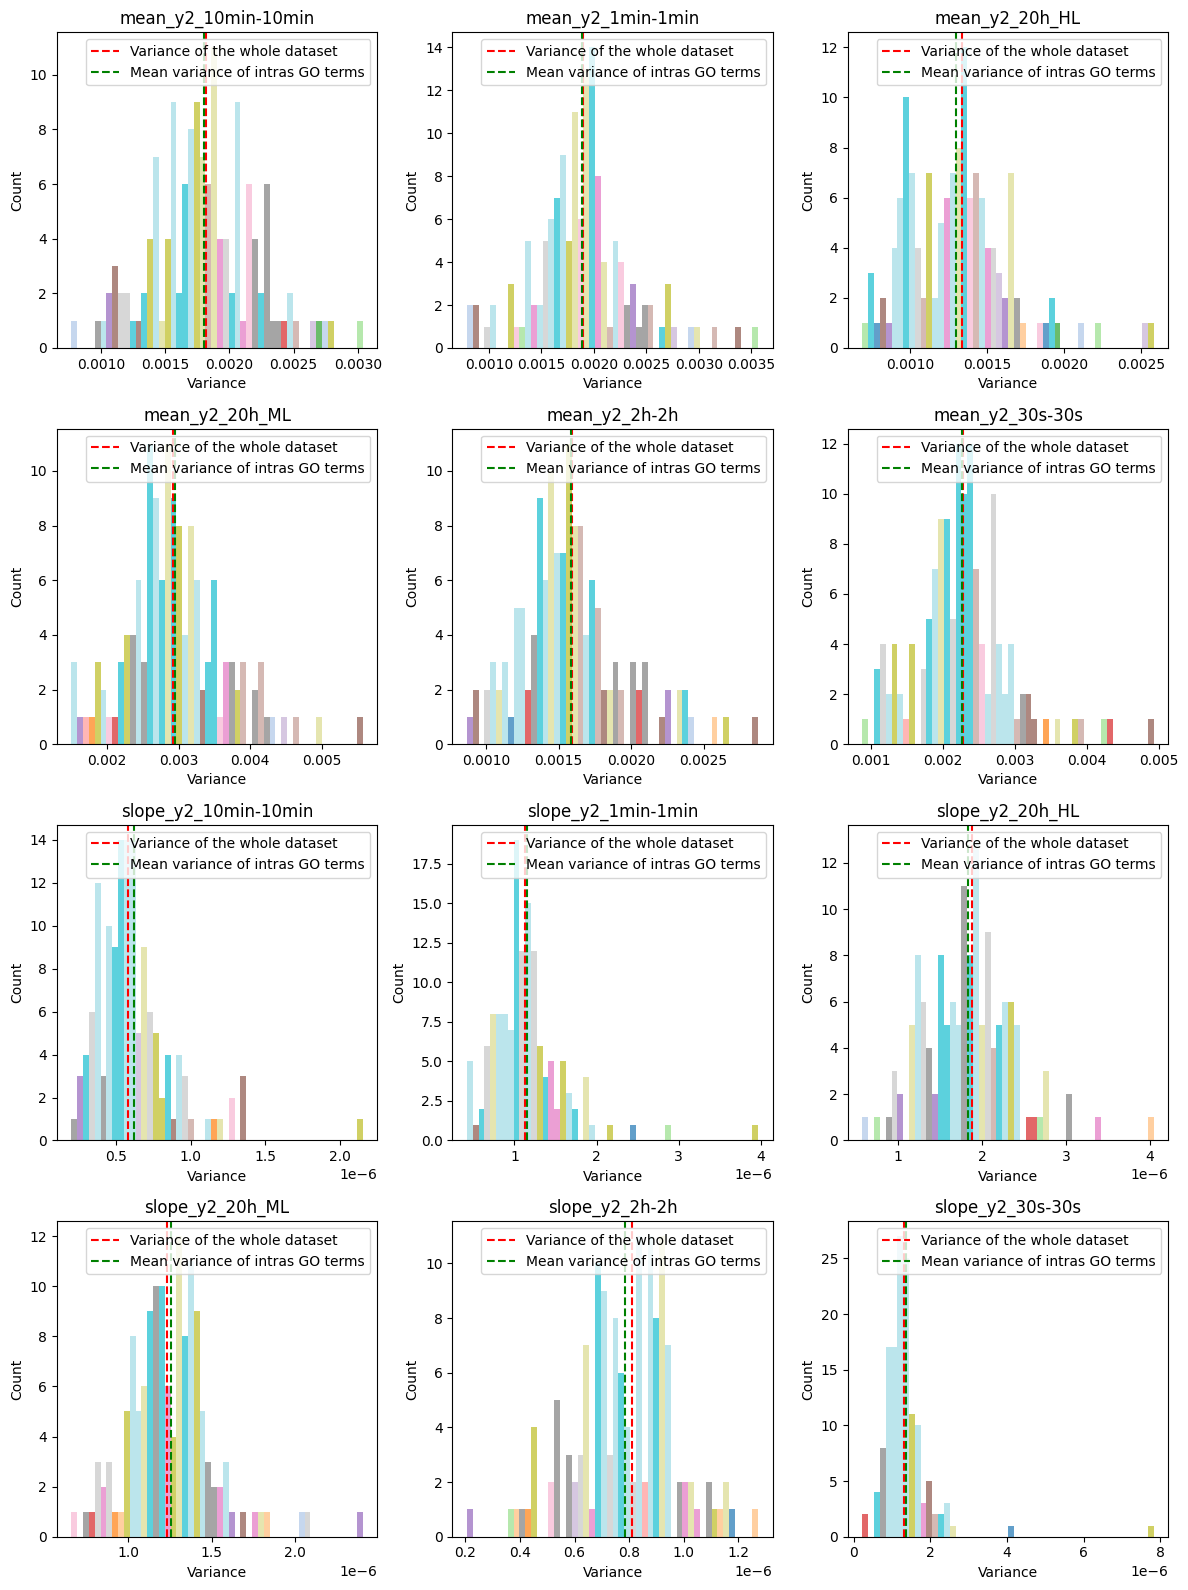

In [54]:
mutant_data_expanded = mutant_data.explode('aggregated_GO')

feature_columns = [col for col in mutant_data_expanded.columns if col.startswith('mean') or col.startswith('slope')]

go_variance = mutant_data_expanded.groupby('aggregated_GO')[feature_columns].var()
var_filtered_expanded_df = mutant_data_expanded[feature_columns].var()

# Plot a histogram of the variance of each feature for the GO terms
num_features = len(feature_columns)
num_rows = (num_features - 1) // 3 + 1

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
colors = plt.cm.get_cmap('tab20', len(go_variance.index))

for i, feature in enumerate(feature_columns):
    ax = axs[i // 3, i % 3]
    variances = go_variance[feature].values
    bins = 50
    color_indices = {go: idx for idx, go in enumerate(go_variance.index)}

    n, bins, patches = ax.hist(variances, bins=bins, color='blue', alpha=0.7)
    
    for go in go_variance.index:
        variance_value = go_variance.loc[go, feature]
        bin_index = min(int((variance_value - bins[0]) / (bins[1] - bins[0])), bins.size - 2)
        patches[bin_index].set_facecolor(colors(color_indices[go]))
        # ax.annotate(go, xy=(variance_value, n[bin_index]), xycoords='data', 
        #             xytext=(0, 5), textcoords='offset points', 
        #             rotation=90, ha='center', va='bottom', fontsize=8)

    ax.axvline(var_filtered_expanded_df[feature], color='red', linestyle='--')
    ax.axvline(go_variance[feature].mean(), color='green', linestyle='--')
    ax.legend(['Variance of the whole dataset', 'Mean variance of intras GO terms'])
    ax.set_title(feature)
    ax.set_xlabel('Variance')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [77]:
# find the mean of the go GO:0016020
go_variance.loc['GO:0016020']

mean_y2_10min-10min     1.888864e-03
mean_y2_1min-1min       1.959876e-03
mean_y2_20h_HL          1.258606e-03
mean_y2_20h_ML          3.084536e-03
mean_y2_2h-2h           1.681249e-03
mean_y2_30s-30s         2.482678e-03
slope_y2_10min-10min    5.226616e-07
slope_y2_1min-1min      1.141501e-06
slope_y2_20h_HL         1.815327e-06
slope_y2_20h_ML         1.366686e-06
slope_y2_2h-2h          8.351173e-07
slope_y2_30s-30s        1.045245e-06
Name: GO:0016020, dtype: float64

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_51504/1735738985.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(go_means.index))


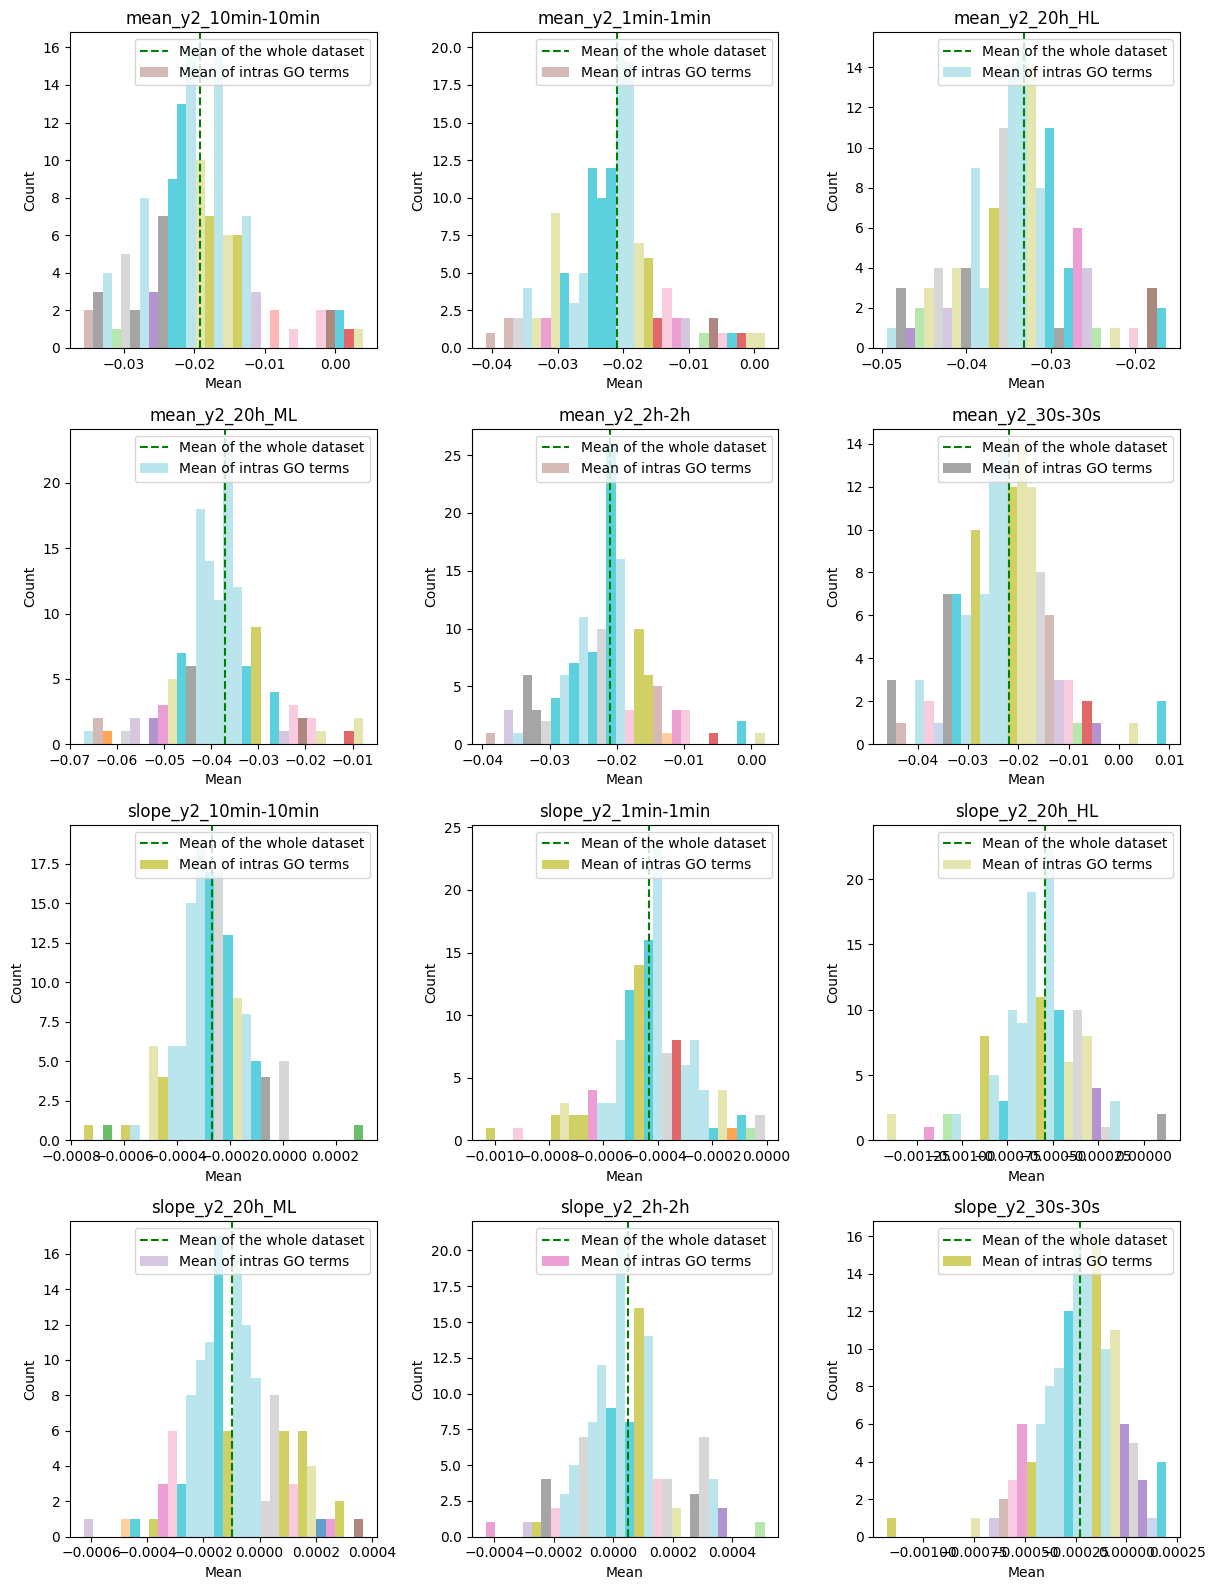

In [55]:
go_means = mutant_data_expanded.groupby('aggregated_GO')[feature_columns].mean()
mean_filtered_expanded_df = mutant_data_expanded[feature_columns].mean()

# Plot a histogram of the means of each feature for the GO terms
num_features = len(feature_columns)
num_rows = (num_features - 1) // 3 + 1

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
colors = plt.cm.get_cmap('tab20', len(go_means.index))

for i, feature in enumerate(feature_columns):
    ax = axs[i // 3, i % 3]
    means = go_means[feature].values
    bins = 30
    color_indices = {go: idx for idx, go in enumerate(go_means.index)}

    n, bins, patches = ax.hist(means, bins=bins, color='blue', alpha=0.7)
    
    for go in go_means.index:
        mean_value = go_means.loc[go, feature]
        bin_index = min(int((mean_value - bins[0]) / (bins[1] - bins[0])), bins.size - 2)
        patches[bin_index].set_facecolor(colors(color_indices[go]))
        # ax.annotate(go, xy=(mean_value, n[bin_index]), xycoords='data', 
        #             xytext=(0, 5), textcoords='offset points', 
        #             rotation=90, ha='center', va='bottom', fontsize=8)

    ax.axvline(mean_filtered_expanded_df[feature], color='green', linestyle='--')
    ax.legend(['Mean of the whole dataset', 'Mean of intras GO terms'])
    ax.set_title(feature)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_51504/3838073849.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(go_means.index))


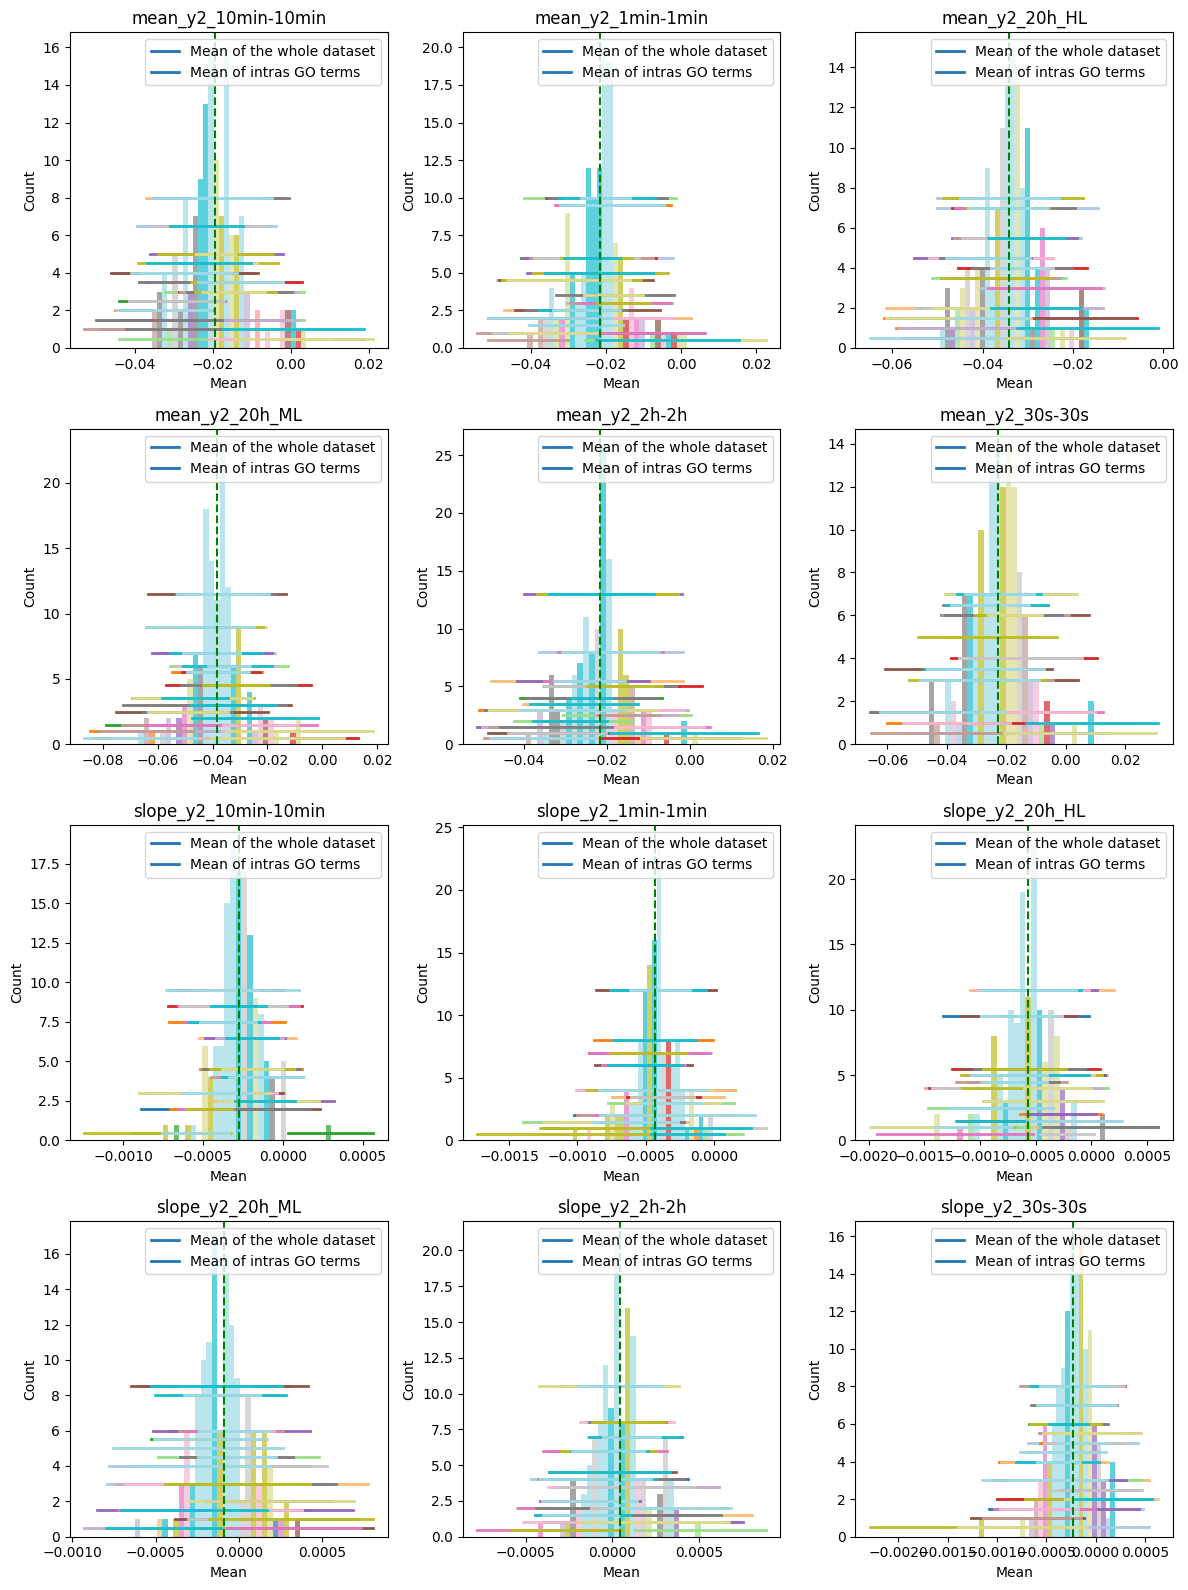

In [56]:
feature_columns = [col for col in mutant_data_expanded.columns if col.startswith('mean') or col.startswith('slope')]

# Calculate means and variances for each GO term
go_variance = mutant_data_expanded.groupby('aggregated_GO')[feature_columns].var()
go_means = mutant_data_expanded.groupby('aggregated_GO')[feature_columns].mean()

# Bootstrapping to create confidence intervals for the means
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    boot_means = np.random.choice(data, (n_bootstrap, len(data)), replace=True).mean(axis=1)
    lower_bound = np.percentile(boot_means, (100 - ci) / 2)
    upper_bound = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

ci_dict = {feature: {} for feature in feature_columns}

for feature in feature_columns:
    for go_term in go_means.index:
        data = mutant_data_expanded[mutant_data_expanded['aggregated_GO'] == go_term][feature].dropna().values
        ci_dict[feature][go_term] = bootstrap_ci(data)

# Plot means and confidence intervals
num_features = len(feature_columns)
num_rows = (num_features - 1) // 3 + 1

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
colors = plt.cm.get_cmap('tab20', len(go_means.index))

for i, feature in enumerate(feature_columns):
    ax = axs[i // 3, i % 3]
    means = go_means[feature].values
    bins = 30
    color_indices = {go: idx for idx, go in enumerate(go_means.index)}

    n, bins, patches = ax.hist(means, bins=bins, color='blue', alpha=0.7)
    
    for go in go_means.index:
        mean_value = go_means.loc[go, feature]
        bin_index = min(int((mean_value - bins[0]) / (bins[1] - bins[0])), bins.size - 2)
        patches[bin_index].set_facecolor(colors(color_indices[go]))
        
        # Get the confidence interval for the current GO term
        ci_lower, ci_upper = ci_dict[feature][go]
        
        # Plot the confidence interval
        ax.plot([ci_lower, ci_upper], [n[bin_index] / 2, n[bin_index] / 2], color=colors(color_indices[go]), lw=2)
        # ax.annotate(go, xy=(mean_value, n[bin_index]), xycoords='data', 
        #             xytext=(0, 5), textcoords='offset points', 
        #             rotation=90, ha='center', va='bottom', fontsize=8)

    ax.axvline(go_means[feature].mean(), color='green', linestyle='--')
    ax.legend(['Mean of the whole dataset', 'Mean of intras GO terms'])
    ax.set_title(feature)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# List of feature columns
features = [col for col in mutant_data_expanded.columns if col.startswith('slope')]

# Initialize list to collect results
results = []

# Iterate over each feature
for feature in features:
    # Rename column to avoid issues with special characters
    renamed_df = mutant_data_expanded.rename(columns={feature: feature.replace('-', '_')})
    
    # ANOVA for the renamed feature
    formula = f'{feature.replace("-", "_")} ~ C(aggregated_GO)'
    model = ols(formula, data=renamed_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-value
    p_value = anova_table["PR(>F)"]["C(aggregated_GO)"]
    
    # Append result
    results.append({'feature': feature, 'p_value': p_value})

# Create DataFrame from results
p_values_df = pd.DataFrame(results)

In [23]:
p_values_df

,feature,p_value
0,slope_y2_10min-10min,0.000030
1,slope_y2_1min-1min,0.510480
2,slope_y2_20h_HL,0.008669
3,slope_y2_20h_ML,0.610375
4,slope_y2_2h-2h,0.010763
5,slope_y2_30s-30s,0.541121


In [74]:
# get the 5% of the GO terms with the lowest means in slope_y2_1min-1min
low_mean_go_terms_mean_1min = go_means['mean_y2_1min-1min'].sort_values().head(int(0.05 * go_means.shape[0])).index
low_mean_go_terms_slope_1min = go_means['slope_y2_1min-1min'].sort_values().head(int(0.05 * go_means.shape[0])).index

In [75]:
def get_go_name(go_id, go_dag):
    if go_id in go_dag:
        return go_dag[go_id].name
    else:
        return None

In [76]:
low_mean_go_terms_mean_1min_names = {go_id: get_go_name(go_id, go_dag) for go_id in low_mean_go_terms_mean_1min}
low_mean_go_terms_slope_1min_names = {go_id: get_go_name(go_id, go_dag) for go_id in low_mean_go_terms_slope_1min}

In [77]:
low_mean_go_terms_mean_1min_names

{'GO:0006508': 'proteolysis', 'GO:1901363': 'heterocyclic compound binding'}

In [78]:
low_mean_go_terms_slope_1min_names

{'GO:0008152': 'metabolic process', 'GO:0043167': 'ion binding'}

In [130]:
go_list = ['GO:0000786', 'GO:0003677', 'GO:0005634', 'GO:0006334']
{go_id: get_go_name(go_id, go_dag) for go_id in go_list}

{'GO:0000786': 'nucleosome',
 'GO:0003677': 'DNA binding',
 'GO:0005634': 'nucleus',
 'GO:0006334': 'nucleosome assembly'}

In [154]:
{go_id: get_go_name(go_id, go_dag) for go_id in go_list}

{'GO:0005524': 'ATP binding',
 'GO:0016491': 'oxidoreductase activity',
 'GO:0004672': 'protein kinase activity',
 'GO:0003824': 'catalytic activity'}

In [29]:
get_go_name('GO:0065003', go_dag)

'protein-containing complex assembly'

In [35]:
data_with_GO_expanded = data_with_GO.explode('aggregated_GO')
# data_with_GO_expanded[data_with_GO_expanded['aggregated_GO'] == 'GO:0043168'].drop_duplicates(subset=['mutant_ID'])

In [36]:
data_with_GO_expanded['aggregated_GO'].value_counts()

aggregated_GO
GO:0005515    5147
GO:0005524    5043
GO:0016020    2512
GO:0042309    2170
GO:0050825    2170
              ... 
GO:0000287     120
GO:0044249     116
GO:0022607     114
GO:0005261     108
GO:0006302     108
Name: count, Length: 139, dtype: int64

In [19]:
from scipy.spatial.distance import pdist, squareform

data_matrix = mutant_data_expanded[['mean_y2_1min-1min']].values[:1000]
distance_matrix = squareform(pdist(data_matrix, metric='euclidean'))

In [27]:
feature_columns_slope = [col for col in mutant_data_expanded.columns if col.startswith('slope')]

In [28]:
feature_columns_slope

['slope_y2_10min-10min',
 'slope_y2_1min-1min',
 'slope_y2_20h_HL',
 'slope_y2_20h_ML',
 'slope_y2_2h-2h',
 'slope_y2_30s-30s']

In [68]:
import networkx as nx
from scipy.spatial.distance import squareform, pdist
from scipy.sparse.csgraph import minimum_spanning_tree

def create_mst(distance_matrix):
    mst_matrix = minimum_spanning_tree(distance_matrix).toarray()
    mst = nx.Graph()
    rows, cols = np.where(mst_matrix > 0)
    for row, col in zip(rows, cols):
        mst.add_edge(row, col, weight=mst_matrix[row, col])
    return mst

data_matrix = mutant_data_expanded.dropna()[feature_columns_slope].values[:5000]
distance_matrix = squareform(pdist(data_matrix, metric='euclidean'))

# Construct the MST
mst = create_mst(distance_matrix)

go_column = 'aggregated_GO'

# Label the nodes based on GO terms
go_labels = mutant_data_expanded.dropna()[go_column].values[:5000]
labels_dict = {i: go_labels[i] for i in range(len(go_labels))}

# Calculate the number of pure edges in the observed MST
observed_pure_edges = calculate_pure_edges(mst, labels_dict)


In [69]:
observed_pure_edges

{'GO:0004672': 2,
 'GO:0016020': 12,
 'GO:0005515': 71,
 'GO:0003824': 2,
 'GO:0006508': 3,
 'GO:0005524': 7,
 'GO:0009987': 1,
 'GO:0000166': 1,
 'GO:0035556': 2,
 'GO:0008152': 5,
 'GO:0005488': 4,
 'GO:0005975': 1,
 'GO:0042309': 10,
 'GO:0006355': 1,
 'GO:0006810': 2,
 'GO:0004713': 9,
 'GO:0030286': 1,
 'GO:0016021': 1,
 'GO:0043412': 1,
 'GO:0003676': 1,
 'GO:0008168': 2,
 'GO:0005634': 1,
 'GO:0055114': 1}

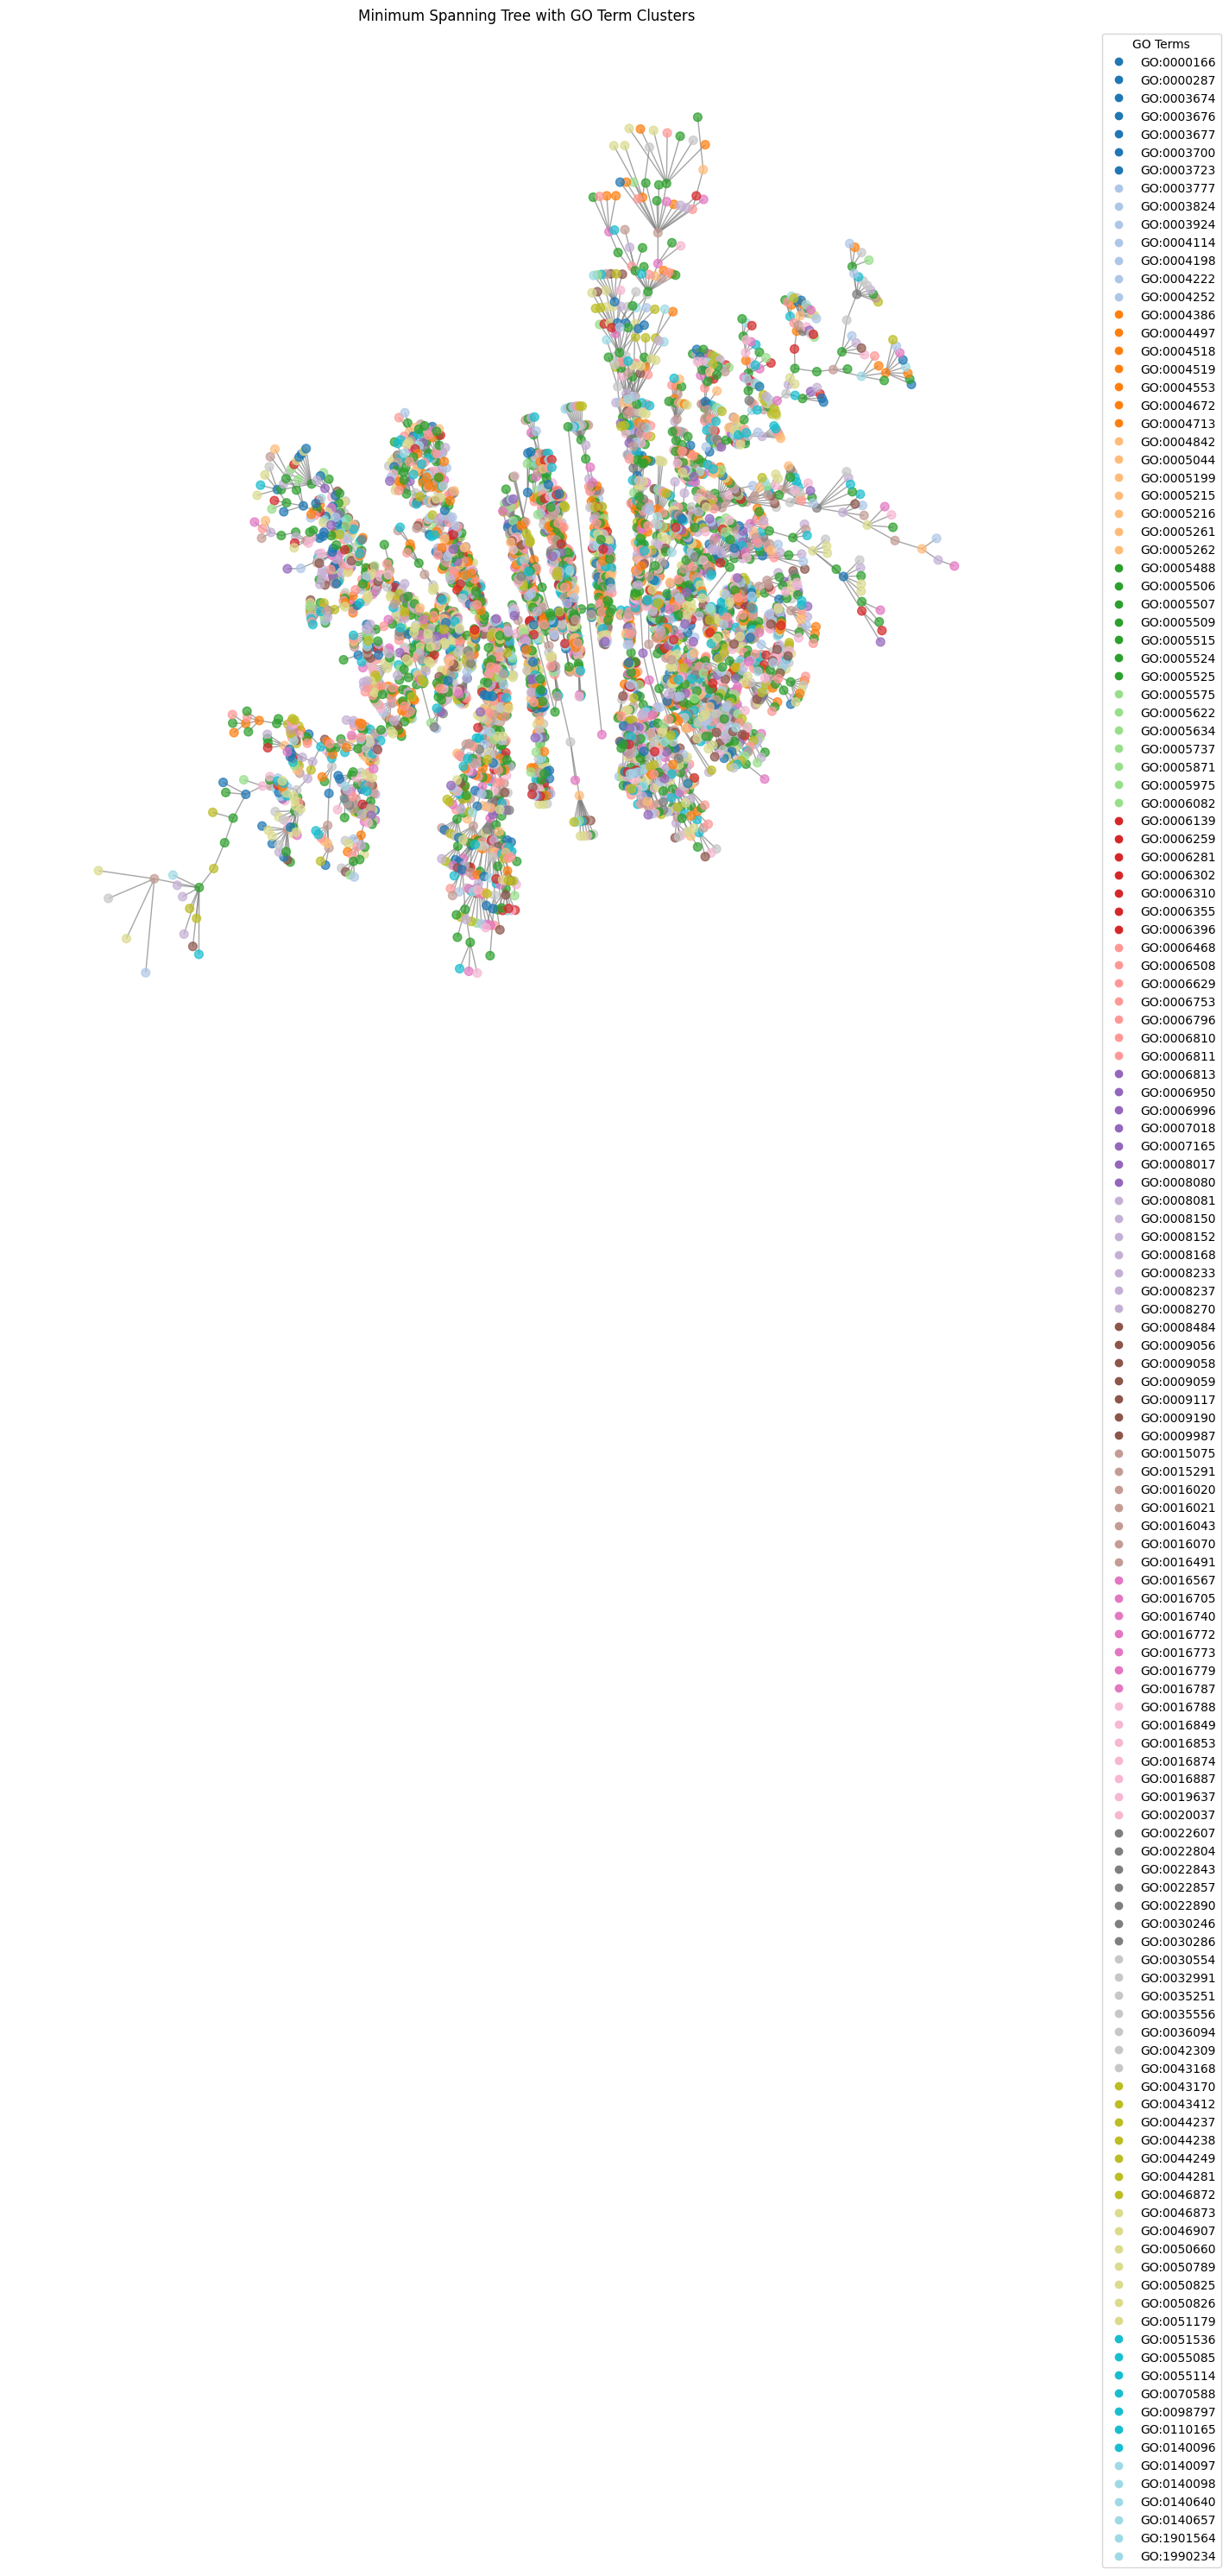

In [71]:
# Assign colors to the nodes based on GO term labels
unique_go_terms = np.unique(go_labels)
color_map = {go: plt.cm.tab20(i / len(unique_go_terms)) for i, go in enumerate(unique_go_terms)}
node_colors = [color_map[labels_dict[node]] for node in mst.nodes()]

# Plot the MST
# pos = nx.spring_layout(mst)  # You can also try pos = nx.kamada_kawai_layout(mst)
pos = nx.kamada_kawai_layout(mst)
plt.figure(figsize=(12, 12))
nx.draw(mst, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color='gray', alpha=0.7)

# Create a legend for GO terms
for go, color in color_map.items():
    plt.plot([], [], color=color, label=go, marker='o', linestyle='None')

plt.legend(title='GO Terms', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Minimum Spanning Tree with GO Term Clusters")
plt.show()

In [32]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform

def calculate_pure_edges(G, labels):
    # pure_edges = 0
    # for u, v in G.edges:
    #     if labels[u] == labels[v]:
    #         pure_edges += 1
    # return pure_edges
    pure_edges_GO = {}
    for u, v in G.edges:
        if labels[u] == labels[v]:
            if labels[u] in pure_edges_GO:
                pure_edges_GO[labels[u]] += 1
            else:
                pure_edges_GO[labels[u]] = 1
    return pure_edges_GO

def permute_labels(labels):
    permuted_labels = labels.copy()
    np.random.shuffle(permuted_labels)
    return permuted_labels

def create_mst(distance_matrix):
    mst_matrix = minimum_spanning_tree(distance_matrix).toarray()
    mst = nx.Graph()
    rows, cols = np.where(mst_matrix > 0)
    for row, col in zip(rows, cols):
        mst.add_edge(row, col, weight=mst_matrix[row, col])
    return mst

def friedman_rafsky_test(df, go_column, feature_columns, n_permutations=1000):
    # Compute the distance matrix
    data_matrix = df[feature_columns].values[:5000]
    distance_matrix = squareform(pdist(data_matrix, metric='euclidean'))

    # Construct the MST
    mst = create_mst(distance_matrix)

    # Label the nodes based on GO terms
    go_labels = df[go_column].values[:5000]
    labels_dict = {i: go_labels[i] for i in range(len(go_labels))}

    # Calculate the number of pure edges in the observed MST
    observed_pure_edges = calculate_pure_edges(mst, labels_dict)

    # Permute the labels and compute the number of pure edges for the null distribution
    null_distribution = []
    for _ in range(n_permutations):
        permuted_labels = permute_labels(go_labels)
        permuted_labels_dict = {i: permuted_labels[i] for i in range(len(permuted_labels))}
        null_pure_edges = calculate_pure_edges(mst, permuted_labels_dict)
        null_distribution.append(null_pure_edges)

    # Calculate the p-value
    # null_distribution = np.array(null_distribution)
    # p_value = np.sum(null_distribution >= observed_pure_edges) / n_permutations

    return observed_pure_edges, null_distribution, p_value

# Perform the Friedman-Rafsky test
observed_pure_edges, null_distribution, p_value = friedman_rafsky_test(
    mutant_data_expanded.dropna(),
    'aggregated_GO',
    feature_columns_slope,
    n_permutations=200
)

# print(f"Observed number of pure edges: {observed_pure_edges}")
print(f"p-value: {p_value}")

# Plot the null distribution
# plt.hist(null_distribution, bins=30, alpha=0.7, color='blue')
# plt.axvline(observed_pure_edges, color='red', linestyle='--')
# plt.xlabel('Number of pure edges')
# plt.ylabel('Frequency')
# plt.title('Null Distribution of Pure Edges')
# plt.show()


p-value: 0.5411206469998512


In [60]:
mutant_data_expanded.dropna()['aggregated_GO'].value_counts()

aggregated_GO
GO:0005515    658
GO:0005524    623
GO:0016020    323
GO:0042309    268
GO:0050825    268
             ... 
GO:0006302     13
GO:0022607     13
GO:0005575     13
GO:0044249     12
GO:0005261     11
Name: count, Length: 139, dtype: int64

In [61]:
def calculate_pure_edges(G, labels):
    pure_edges_GO = {}
    for u, v in G.edges:
        if labels[u] == labels[v]:
            if labels[u] in pure_edges_GO:
                pure_edges_GO[labels[u]] += 1
            else:
                pure_edges_GO[labels[u]] = 1
    return pure_edges_GO

def permute_labels(labels):
    permuted_labels = labels.copy()
    np.random.shuffle(permuted_labels)
    return permuted_labels

def create_mst(distance_matrix):
    mst_matrix = minimum_spanning_tree(distance_matrix).toarray()
    mst = nx.Graph()
    rows, cols = np.where(mst_matrix > 0)
    for row, col in zip(rows, cols):
        mst.add_edge(row, col, weight=mst_matrix[row, col])
    return mst

def friedman_rafsky_test(df, go_column, feature_columns, n_permutations=1000):
    # Compute the distance matrix
    data_matrix = df[feature_columns].values[:8000]
    distance_matrix = squareform(pdist(data_matrix, metric='euclidean'))

    # Construct the MST
    mst = create_mst(distance_matrix)

    # Label the nodes based on GO terms
    go_labels = df[go_column].values[:8000]
    labels_dict = {i: go_labels[i] for i in range(len(go_labels))}

    # Calculate the number of pure edges in the observed MST
    observed_pure_edges = calculate_pure_edges(mst, labels_dict)

    # Initialize dictionary to store null distributions for each GO term
    null_distributions = {go: [] for go in np.unique(go_labels)}

    # Permute the labels and compute the number of pure edges for the null distribution
    for _ in range(n_permutations):
        permuted_labels = permute_labels(go_labels)
        permuted_labels_dict = {i: permuted_labels[i] for i in range(len(permuted_labels))}
        null_pure_edges = calculate_pure_edges(mst, permuted_labels_dict)

        # Store the null pure edges for each GO term
        for go in null_pure_edges:
            null_distributions[go].append(null_pure_edges[go])

    # Calculate p-values for each GO term
    p_values = {}
    for go in observed_pure_edges:
        if go in null_distributions:
            null_distribution = null_distributions[go]
            observed_value = observed_pure_edges[go]
            p_value = np.sum(np.array(null_distribution) >= observed_value) / n_permutations
            p_values[go] = p_value

    return observed_pure_edges, null_distributions, p_values

# Perform the Friedman-Rafsky test
observed_pure_edges, null_distributions, p_values = friedman_rafsky_test(
    mutant_data_expanded.dropna(),
    'aggregated_GO',
    feature_columns_slope,
    n_permutations=500
)

# Print p-values for each GO term
for go, p_value in p_values.items():
    print(f"GO Term: {go}, p-value: {p_value}")


GO Term: GO:0005515, p-value: 0.0
GO Term: GO:0003824, p-value: 0.53
GO Term: GO:0016020, p-value: 0.004
GO Term: GO:0009987, p-value: 0.446
GO Term: GO:0005506, p-value: 0.17
GO Term: GO:0008152, p-value: 0.228
GO Term: GO:0042309, p-value: 0.004
GO Term: GO:0006813, p-value: 0.026
GO Term: GO:0005524, p-value: 1.0
GO Term: GO:0006810, p-value: 0.058
GO Term: GO:0004713, p-value: 0.0
GO Term: GO:0006508, p-value: 0.418
GO Term: GO:0005488, p-value: 0.162
GO Term: GO:0035556, p-value: 0.068
GO Term: GO:0004672, p-value: 0.97
GO Term: GO:0055085, p-value: 0.746
GO Term: GO:0030286, p-value: 0.18
GO Term: GO:0016021, p-value: 0.522
GO Term: GO:0043412, p-value: 0.016
GO Term: GO:0008168, p-value: 0.01
GO Term: GO:0003676, p-value: 0.668
GO Term: GO:0006355, p-value: 0.382
GO Term: GO:0005634, p-value: 0.168
GO Term: GO:0050660, p-value: 0.09
GO Term: GO:0055114, p-value: 0.91
GO Term: GO:0005509, p-value: 0.418
GO Term: GO:0008270, p-value: 0.704


In [73]:
go_dag['GO:0016020']

GOTerm('GO:0016020'):
  id:GO:0016020
  item_id:GO:0016020
  name:membrane
  namespace:cellular_component
  _parents: 1 items
    GO:0110165
  parents: 1 items
    GO:0110165	level-01	depth-01	cellular anatomical entity [cellular_component]
  children: 16 items
  level:2
  depth:2
  is_obsolete:False
  alt_ids: 3 items
    GO:0016021
    GO:0098805
    GO:0098589

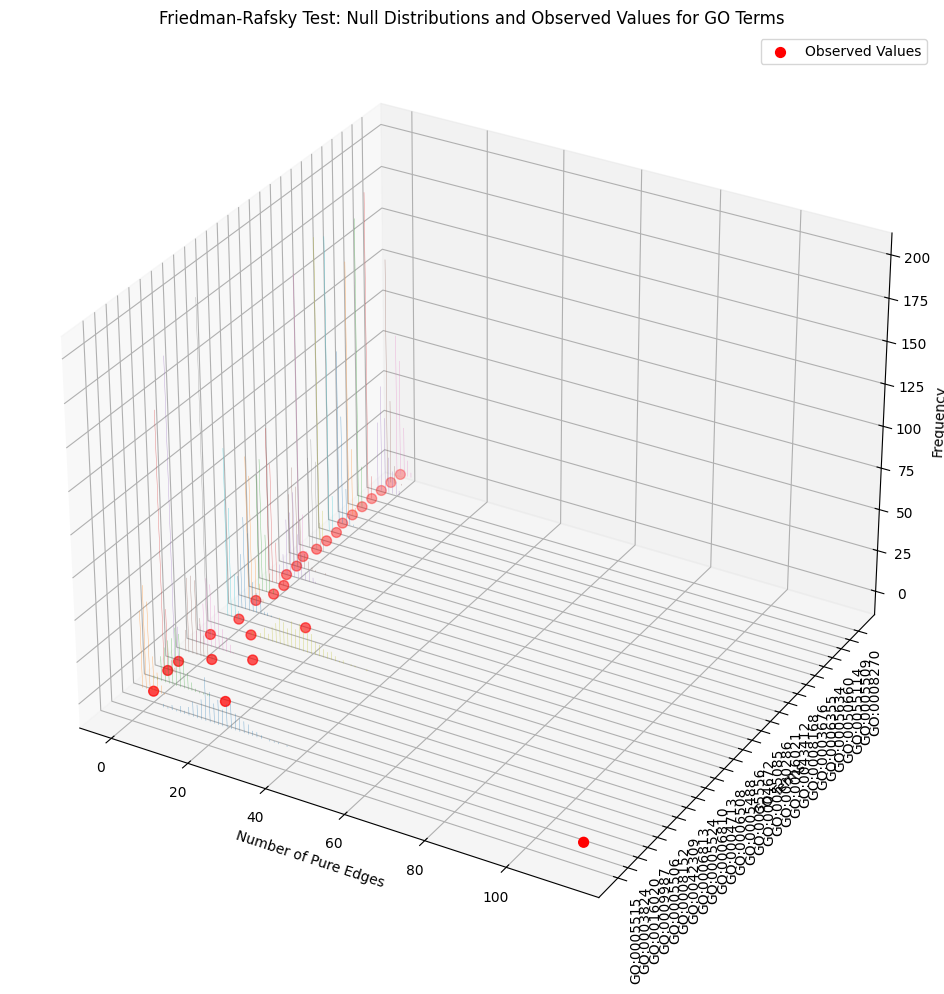

In [62]:
# Prepare data for plotting
go_terms = list(observed_pure_edges.keys())
num_go_terms = len(go_terms)
x_positions = np.arange(num_go_terms)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot null distributions for each GO term as histograms
for i, go_term in enumerate(go_terms):
    null_values = [null[go_term] if go_term in null else 0 for null in null_distribution]
    hist, bins = np.histogram(null_values, bins=30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(bin_centers, hist, zs=i, zdir='y', alpha=0.7, width=0.1)

# Plot observed values for each GO term
observed_values = [observed_pure_edges[go_term] for go_term in go_terms]
ax.scatter(observed_values, x_positions, zs=0, zdir='z', c='red', s=50, label='Observed Values')

# Set labels and title
ax.set_xlabel('Number of Pure Edges')
ax.set_ylabel('GO Terms')
ax.set_zlabel('Frequency')
ax.set_title('Friedman-Rafsky Test: Null Distributions and Observed Values for GO Terms')

# Set ticks for GO terms
ax.set_yticks(x_positions)
ax.set_yticklabels(go_terms, rotation=90)

ax.legend()
plt.show()

In [153]:
go_list = ['GO:0005524', 'GO:0016491', 'GO:0004672', 'GO:0003824']

In [93]:
# get the 5% of the GO terms with the highest number of pure edges in the observed_pure_edges dict
sorted_pure_edges = {k: v for k, v in sorted(observed_pure_edges.items(), key=lambda item: item[1], reverse=True)}
top_pure_edges_go_terms = list(sorted_pure_edges.keys())[:int(0.05 * len(sorted_pure_edges))]
top_pure_edges_go_terms

['GO:0005515']

In [94]:
go_dag['GO:0005515'].name

'protein binding'

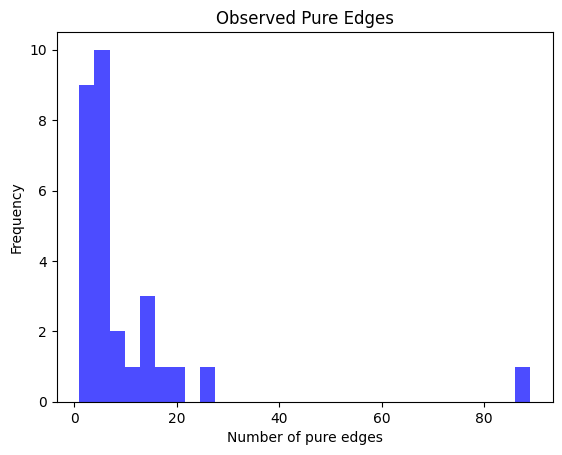

In [133]:
# plot a hist of the values of the observed_pure_edges dict
plt.hist(observed_pure_edges.values(), bins=30, alpha=0.7, color='blue')
plt.xlabel('Number of pure edges')
plt.ylabel('Frequency')
plt.title('Observed Pure Edges')
plt.show()

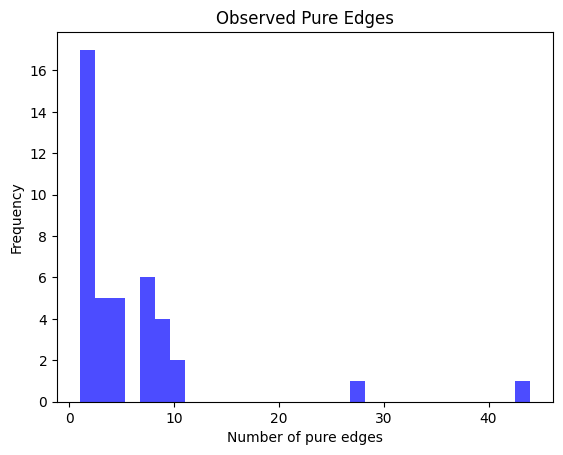

In [136]:
# plot a hist of the values of the null_distribution dict
plt.hist(null_distribution[0].values(), bins=30, alpha=0.7, color='blue')
plt.xlabel('Number of pure edges')
plt.ylabel('Frequency')
plt.title('Observed Pure Edges')
plt.show()

<Axes: >

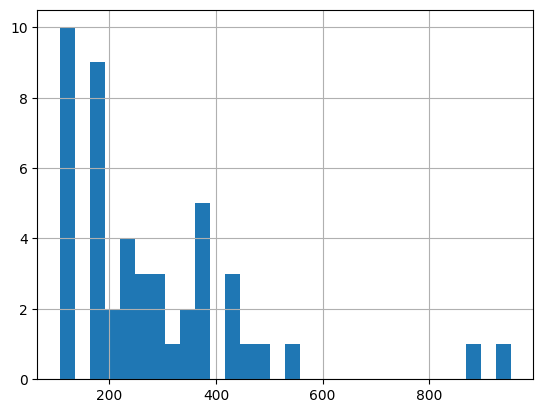

In [135]:
df_mutants_gene_go['aggregated_GO'].explode().value_counts().hist(bins=30)

In [155]:
mutant_list = pd.read_csv('final_mutants_for_screen_05_14_2024.csv')

In [156]:
data_norm_flagged_mutant_list = data_norm_flagged[data_norm_flagged['mutant_ID'].isin(mutant_list['mutant_ID'])]

In [157]:
data_norm_flagged_mutant_list

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,mean_ynpq,median,log_likelihood_null,GO,mutated_genes_light_regime_count,fv_fm_WT,fv_fm_end_WT,ynpqend_WT,flag_y2,flag_ynpq
771,2,M1,2023-10-18,1min-1min,17.221402,25.338585,164,0,5,-0.020655,...,-0.006933,None,None,"[GO:0005488, GO:0005515]",4,0.609441,0.589635,-0.025696,ok,ok
790,2,M1,2023-10-18,1min-1min,17.221402,25.338585,164,0,22,0.069263,...,0.016062,None,None,[],5,0.609441,0.589635,-0.025696,weird,weird
794,2,M1,2023-10-18,1min-1min,17.221402,25.338585,164,1,2,-0.007336,...,-0.010102,None,None,[GO:0004866],4,0.609441,0.589635,-0.025696,weird,weird
795,2,M1,2023-10-18,1min-1min,17.221402,25.338585,164,1,3,-0.019832,...,-0.077858,None,None,[],3,0.609441,0.589635,-0.025696,ok,weird
796,2,M1,2023-10-18,1min-1min,17.221402,25.338585,164,1,3,-0.019832,...,-0.077858,None,None,[],5,0.609441,0.589635,-0.025696,ok,weird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53482,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,14,8,0.066164,...,0.022345,None,None,[],4,0.638787,0.605804,0.002948,weird,weird
53483,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,14,8,0.066164,...,0.022345,None,None,[],2,0.638787,0.605804,0.002948,weird,ok
53487,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,14,11,-0.053347,...,-0.042018,None,None,[],2,0.638787,0.605804,0.002948,weird,weird
53502,6,M6,2024-04-22,30s-30s,15.294150,28.350881,164,15,2,-0.051476,...,-0.049734,None,None,"[GO:0005215, GO:0006810, GO:0016020]",3,0.638787,0.605804,0.002948,ok,ok


In [158]:
mutant_list

,Unnamed: 0,mutant_ID,mutated_genes,plate,i (converted to letter),j,source_df
0,0,LMJ.RY0402.052879,Cre16.g675350,20,C,15,light_specific_y2
1,1,LMJ.RY0402.046388,Cre11.g476050,23,G,8,light_specific_y2
2,2,LMJ.RY0402.219441,Cre12.g524750,22,L,6,light_specific_y2
3,3,LMJ.RY0402.135927,Cre12.g538550,21,G,4,light_specific_y2
4,4,LMJ.RY0402.243547,Cre16.g647850,23,J,5,light_specific_y2
...,...,...,...,...,...,...,...
530,1159,LMJ.RY0402.209920,Cre10.g444000,12,C,6,special_mutants_y2
531,1160,LMJ.RY0402.217896,Cre10.g444000,12,M,8,special_mutants_y2
532,1167,LMJ.RY0402.252269,Cre10.g444000,15,A,22,special_mutants_y2
533,1173,LMJ.RY0402.134589,Cre10.g444000,18,D,20,special_mutants_y2


In [160]:
from matplotlib.backends.backend_pdf import PdfPages

# Define a sorting key function using the order_map
def custom_sort_key(value):
    return order_map.get(value, len(desired_order))

elapsed_time_columns = [col for col in data_slopes.columns if 'elapsed_time' in col]

already_seen_genes = []

# Define the gene of interest and light regimes
# gene_of_interest = selected_genes_filtered[5]
# gene_of_interest = data_cluster[data_cluster['mutated_genes'].isin(selected_genes_filtered)].sort_values(by='slope_y2')['mutated_genes'].unique()[4]
# gene_of_interest = data_cluster['mutated_genes'].unique()[200]
# gene_of_interest = final_mutants['mutated_genes'].unique()[180]
# gene_of_interest = data_norm_flagged.sort_values(by='mean_reduced_v2_y2', ascending=False)['mutated_genes'].unique()[350]

with PdfPages('plots_firs_mutant_list_05_14_2024.pdf') as pdf:
    for i in range(mutant_list['mutant_ID'].nunique()):
        mutant_of_interest = mutant_list['mutant_ID'].unique()[i]
        # mutant_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutant_ID'].unique()[i]
        gene_of_interest = data_slopes[(data_slopes['mutant_ID'] == mutant_of_interest)]['mutated_genes'].unique()[0]
        if gene_of_interest in already_seen_genes:
            continue
        already_seen_genes.append(gene_of_interest)
        # gene_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutated_genes'].unique()[i]
        # Define the desired order
        desired_order = ['20h_HL', '20h_ML', '2h-2h', '10min-10min', '1min-1min', '30s-30s']

        # Create a dictionary to map each value to its position in the desired order
        order_map = {value: index for index, value in enumerate(desired_order)}

        # Sample array containing some of the values
        # light_regimes = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest)]['light_regime'].unique()
        light_regimes = data_slopes[(data_slopes['mutated_genes'] == gene_of_interest)]['light_regime'].unique()

        # Sort the array using the custom sort key
        sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)
        titles = ['Y(II) for gene ' + str(gene_of_interest) + ' in ' + light for light in sorted_light_regimes]
        colors = ['b', 'r', 'g', 'k', 'purple', 'grey']
        colors = colors[:len(titles)]

        # Prepare subplot layout
        fig, axes = plt.subplots(1, len(titles), figsize=(25, 5))

        # Iterate over light regimes and plot Y(II) values
        for j, (light_regime, color, title) in enumerate(zip(sorted_light_regimes, colors, titles)):
            # Filter data for the current gene and light regime
            # filtered_data = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest) & 
            #                                     (data_slope_cluster['light_regime'] == light_regime)]
            filtered_data = data_slopes[(data_slopes['mutated_genes'] == gene_of_interest) & 
                                                (data_slopes['light_regime'] == light_regime)]
            # Extract Y(II) values and plot each line
            y2_values = filtered_data.filter(regex=r'^y2_\d+$').dropna(axis=1).values
            for k in range(y2_values.shape[0]):
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:-1]
                color = 'b'
                axes[j].plot(elapsed_time, y2_values[k], c=color, alpha=0.4, label='Mutant {}'.format(k+1))
            
            axes[j].axhline(y=0, color='black', linestyle='--')
            # Set title and other plot properties
            axes[j].set_title(title)
            axes[j].set_xlabel('Time (h)', fontsize=18)
            axes[j].set_ylabel('Y(II)', fontsize=18)
            axes[j].set_ylim(-0.2, 0.2)
            axes[j].legend(loc='upper right', fontsize='small')


        # Adjust layout and display the plot
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)


In [162]:
pd.set_option('display.max_columns', None)

In [164]:
data_slopes[data_slopes['mutated_genes'] == 'Cre12.g544114']

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,mask_area,y2_1,y2_2,y2_3,y2_4,y2_5,y2_6,y2_7,y2_8,y2_9,y2_10,y2_11,y2_12,y2_13,y2_14,y2_15,y2_16,y2_17,y2_18,y2_19,y2_20,y2_21,y2_22,y2_23,y2_24,y2_25,y2_26,y2_27,y2_28,y2_29,y2_30,y2_31,y2_32,y2_33,y2_34,y2_35,y2_36,y2_37,y2_38,y2_39,y2_40,y2_41,y2_42,y2_43,y2_44,y2_45,y2_46,y2_47,y2_48,y2_49,y2_50,y2_51,y2_52,y2_53,y2_54,y2_55,y2_56,y2_57,y2_58,y2_59,y2_60,y2_61,y2_62,y2_63,y2_64,y2_65,y2_66,y2_67,y2_68,y2_69,y2_70,y2_71,y2_72,y2_73,y2_74,y2_75,y2_76,y2_77,y2_78,y2_79,y2_80,ynpq_1,ynpq_2,ynpq_3,ynpq_4,ynpq_5,ynpq_6,ynpq_7,ynpq_8,ynpq_9,ynpq_10,ynpq_11,ynpq_12,ynpq_13,ynpq_14,ynpq_15,ynpq_16,ynpq_17,ynpq_18,ynpq_19,ynpq_20,ynpq_21,ynpq_22,ynpq_23,ynpq_24,ynpq_25,ynpq_26,ynpq_27,ynpq_28,ynpq_29,ynpq_30,ynpq_31,ynpq_32,ynpq_33,ynpq_34,ynpq_35,ynpq_36,ynpq_37,ynpq_38,ynpq_39,ynpq_40,ynpq_41,ynpq_42,ynpq_43,ynpq_44,ynpq_45,ynpq_46,ynpq_47,ynpq_48,ynpq_49,ynpq_50,ynpq_51,ynpq_52,ynpq_53,ynpq_54,ynpq_55,ynpq_56,ynpq_57,ynpq_58,ynpq_59,ynpq_60,ynpq_61,ynpq_62,ynpq_63,ynpq_64,ynpq_65,ynpq_66,ynpq_67,ynpq_68,ynpq_69,ynpq_70,ynpq_71,ynpq_72,ynpq_73,ynpq_74,ynpq_75,ynpq_76,ynpq_77,ynpq_78,ynpq_79,ynpq_80,measurement_time_0,measurement_time_1,measurement_time_2,measurement_time_3,measurement_time_4,measurement_time_5,measurement_time_6,measurement_time_7,measurement_time_8,measurement_time_9,measurement_time_10,measurement_time_11,measurement_time_12,measurement_time_13,measurement_time_14,measurement_time_15,measurement_time_16,measurement_time_17,measurement_time_18,measurement_time_19,measurement_time_20,measurement_time_21,measurement_time_22,measurement_time_23,measurement_time_24,measurement_time_25,measurement_time_26,measurement_time_27,measurement_time_28,measurement_time_29,measurement_time_30,measurement_time_31,measurement_time_32,measurement_time_33,measurement_time_34,measurement_time_35,measurement_time_36,measurement_time_37,measurement_time_38,measurement_time_39,measurement_time_40,measurement_time_41,measurement_time_42,measurement_time_43,measurement_time_44,measurement_time_45,measurement_time_46,measurement_time_47,measurement_time_48,measurement_time_49,measurement_time_50,measurement_time_51,measurement_time_52,measurement_time_53,measurement_time_54,measurement_time_55,measurement_time_56,measurement_time_57,measurement_time_58,measurement_time_59,measurement_time_60,measurement_time_61,measurement_time_62,measurement_time_63,measurement_time_64,measurement_time_65,measurement_time_66,measurement_time_67,measurement_time_68,measurement_time_69,measurement_time_70,measurement_time_71,measurement_time_72,measurement_time_73,measurement_time_74,measurement_time_75,measurement_time_76,measurement_time_77,measurement_time_78,measurement_time_79,measurement_time_80,measurement_time_81,F_0,Fm_0,F_1,Fm_1,F_2,Fm_2,F_3,Fm_3,F_4,Fm_4,F_5,Fm_5,F_6,Fm_6,F_7,Fm_7,F_8,Fm_8,F_9,Fm_9,F_10,Fm_10,F_11,Fm_11,F_12,Fm_12,F_13,Fm_13,F_14,Fm_14,F_15,Fm_15,F_16,Fm_16,F_17,Fm_17,F_18,Fm_18,F_19,Fm_19,F_20,Fm_20,F_21,Fm_21,F_22,Fm_22,F_23,Fm_23,F_24,Fm_24,F_25,Fm_25,F_26,Fm_26,F_27,Fm_27,F_28,Fm_28,F_29,Fm_29,F_30,Fm_30,F_31,Fm_31,F_32,Fm_32,F_33,Fm_33,F_34,Fm_34,F_35,Fm_35,F_36,Fm_36,F_37,Fm_37,F_38,Fm_38,F_39,Fm_39,F_40,Fm_40,F_41,Fm_41,F_42,Fm_42,F_43,Fm_43,F_44,Fm_44,F_45,Fm_45,F_46,Fm_46,F_47,Fm_47,F_48,Fm_48,F_49,Fm_49,F_50,Fm_50,F_51,Fm_51,F_52,Fm_52,F_53,Fm_53,F_54,Fm_54,F_55,Fm_55,F_56,Fm_56,F_57,Fm_57,F_58,Fm_58,F_59,Fm_59,F_60,Fm_60,F_61,Fm_61,F_62,Fm_62,F_63,Fm_63,F_64,Fm_64,F_65,Fm_65,F_66,Fm_66,F_67,Fm_67,F_68,Fm_68,F_69,Fm_69,F_70,Fm_70,F_71,Fm_71,F_72,Fm_72,F_73,Fm_73,F_74,Fm_74,F_75,Fm_75,F_76,Fm_76,F_77,Fm_77,F_78,Fm_78,F_79,Fm_79,F_80,Fm_80,F_81,Fm_81,well_id,mutant_ID,feature,mutated_genes,num_mutations,fv_fm_end,ynpqend,new_record_fv_fm,elapsed_time_0,elapsed_time_1,elapsed_time_2,elapsed_time_3,elapsed_time_4,elapsed_time_5,elapsed_time_6,elapsed_time_7,elapsed_time_8,elapsed_time_9,elapsed_time_10,elapsed_time_11,elapsed_ti